In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2024-05-23 15:13:12.753402: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 15:13:12.813787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 15:13:13.584774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def crop_minAreaRect(src, rect, output_size=(64, 64)):
    if len(src.shape) != 2:
        raise ValueError(
            "crop_minAreaRect(): Source image should be in grayscale, and have two dimensions."
        )

    (_, (width, height), angle) = rect
    if width == 0 or height == 0:
        raise ValueError("crop_minAreaRect(): Bounding box does not exist.")

    # Rotate image to the angle of the bounding box
    rows, cols = src.shape
    M = cv2.getRotationMatrix2D(
        (height / 2.0, width / 2.0), angle, 1
    )  # width = number of columns, and height = number of rows.
    img_rot = cv2.warpAffine(src, M, (rows, cols))

    # Rotate bounding box
    box = cv2.boxPoints(rect)  # coordinates of four points of the box
    points = np.intp(cv2.transform(np.array([box]), M))[0]
    points[points < 0] = 0

    # # Compute the center of the bounding box
    # center_x, center_y = np.mean(points[:, 0]), np.mean(points[:, 1])

    # # Determine the top-left corner of the cropping rectangle
    # top_left_x = int(center_x - output_size[0] / 2)
    # top_left_y = int(center_y - output_size[1] / 2)

    # # Ensure the cropping rectangle is within the image bounds
    # top_left_x = max(0, top_left_x)
    # top_left_y = max(0, top_left_y)
    # bottom_right_x = min(cols, top_left_x + output_size[0])
    # bottom_right_y = min(rows, top_left_y + output_size[1])

    # # Adjust the top-left corner if the cropping rectangle is out of bounds
    # if bottom_right_x - top_left_x < output_size[0]:
    #     top_left_x = max(0, bottom_right_x - output_size[0])
    # if bottom_right_y - top_left_y < output_size[1]:
    #     top_left_y = max(0, bottom_right_y - output_size[1])

    img_rot[pts[1][1] : pts[0][1], pts[1][0] : pts[2][0]]

    # crop_img = img[0:400, 0:300] # Crop from {x, y, w, h } => {0, 0, 300, 400}

    # Crop the image
    img_crop = img_rot[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

    # Make long side up
    if height < width:
        img_crop = cv2.rotate(img_crop, cv2.ROTATE_90_CLOCKWISE)

    return img_crop

In [4]:
# crop_img = img[0:400, 0:300] # Crop from {x, y, w, h } => {0, 0, 300, 400}

In [5]:
def crop_minAreaRect(img, rect, output_size=64):
    # Rotate the image
    angle = rect[2]
    rows, cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img_rot = cv2.warpAffine(img, M, (cols, rows))

    # Rotate the bounding box
    # rect0 = (rect[0], rect[1], angle)
    box = cv2.boxPoints(rect)
    pts = np.intp(cv2.transform(np.array([box]), M))[0]
    pts[pts < 0] = 0

    # # Crop the image
    # img_crop = img_rot[pts[1][1]:pts[0][1], pts[1][0]:pts[2][0]]
    output_size = 64  # Replace 32 with the desired output size
    half_size = output_size // 2

    h, w = box.shape[:2]

    # Calculate the center of the original image
    center_y, center_x = h // 2, w // 2

    # Calculate the top-left corner of the crop region
    start_y = max(center_y - half_size, 0)
    start_x = max(center_x - half_size, 0)

    # Calculate the bottom-right corner of the crop region
    end_y = min(center_y + half_size, h)
    end_x = min(center_x + half_size, w)

    # Ensure the crop area is exactly output_size x output_size, adjusting if at the image edges
    if end_y - start_y < output_size:
        start_y = max(end_y - output_size, 0)
    if end_x - start_x < output_size:
        start_x = max(end_x - output_size, 0)

    # Crop the image
    img_crop = img_rot[start_y:end_y, start_x:end_x]

    # # If necessary, resize the crop to ensure it's exactly output_size x output_size
    # if img_crop.shape[:2] != (output_size, output_size):
    #     img_crop = cv2.resize(img_crop, (output_size, output_size))

    # # Define the starting point for the crop
    # start_y, start_x = pts[1][1], pts[1][0]

    # # Define the ending point for the crop to be exactly 32x32 pixels
    # end_y, end_x = start_y + output_size, start_x + output_size

    # # Ensure the crop area does not exceed the image boundaries
    # end_y = min(end_y, img_rot.shape[0])
    # end_x = min(end_x, img_rot.shape[1])

    # # Crop the image
    # img_crop = img_rot[start_y:end_y, start_x:end_x]

    # h, w = img_crop.shape[:2]
    # if h < w:
    #     img_crop = cv2.rotate(img_crop, cv2.ROTATE_90_CLOCKWISE)
    #     h, w = w, h

    # pad_bottom, pad_right = 0, 0
    # ratio =  h / w

    # if h > output_size:
    #     # shrinking image algorithm
    #     interp = cv2.INTER_AREA
    # else:
    #     # stretching image algorithm
    #     interp = cv2.INTER_CUBIC

    # w = output_size
    # h = round(w * ratio)
    # pad_bottom = abs(output_size - h)
    # pad_right = abs(output_size - w)

    # scaled_img = cv2.resize(img, (w, h), interpolation=interp)

    # padded_img = cv2.copyMakeBorder(scaled_img,0,pad_bottom,0,pad_right,borderType=cv2.BORDER_CONSTANT,value=[0,0,0])

    return img_crop

dtype: uint8, shape: (104, 104), min: 144, max: 255


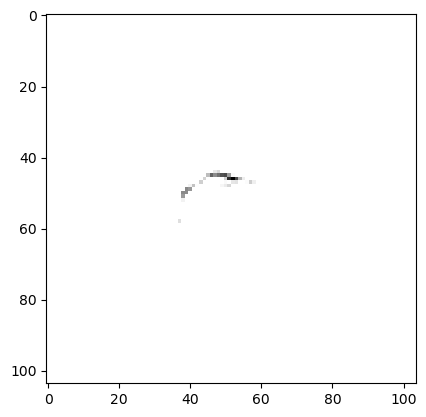

In [41]:
path = "/home/t.afanasyeva/research_storage/Processing/Lab - Van Dam/datasets/srf_anaemias/raw/24-711122-104x104/1.tif"
# img_16 = cv2.imread(path, cv2.IMREAD_UNCHANGED) # for
# np_uint16 = np.arange(2 ** 16, dtype=np.uint16).reshape(256, 256)
# np_uint8 = (np_int16 // 256).astype(np.uint8)

# img = cv2.imread(path)
# img = cv2.convertScaleAbs(img_16)

assert img is not None, "file could not be read, check with os.path.exists()"

print(f"dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}")
plt.imshow(img, "gray")

In [8]:
# img = tf.image.convert_image_dtype(img, tf.float32)
# res = tf.image.resize(img, [50, 50], preserve_aspect_ratio=True)
# plt.imshow(res, "gray")

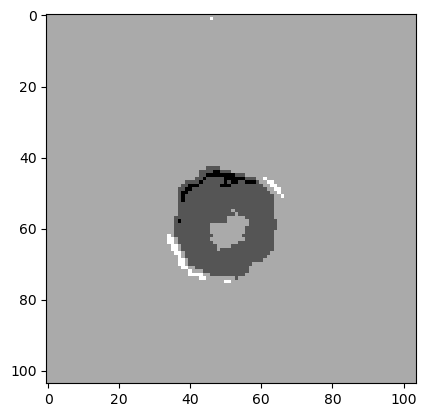

In [38]:
# filt = cv2.pyrMeanShiftFiltering(img, sp=10, sr=30, maxLevel=1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="grey")

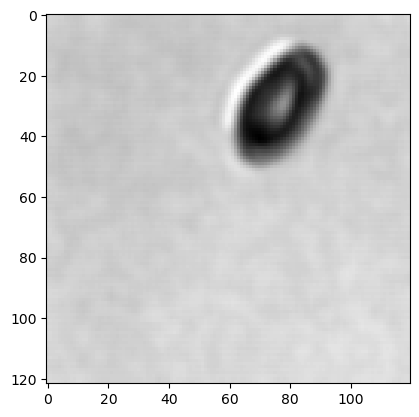

In [10]:
# Smooth image
blur = cv2.GaussianBlur(gray, (5, 5), 3)
plt.imshow(blur, cmap="grey")

False


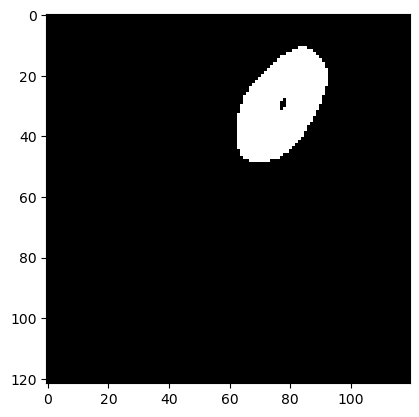

In [11]:
def is_image_empty(image):
    # Check if all elements in the image are zero
    return np.all(image == 0)


_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# thresh = np.zeros((3,3)) # to check if cells are present
print(is_image_empty(thresh))

thresh = 255 - thresh
plt.imshow(thresh, cmap="gray")

In [12]:
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

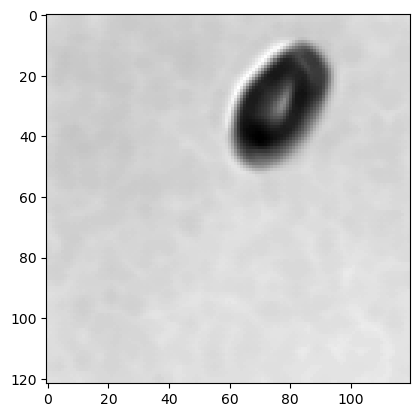

In [13]:
radius = 1  # Define the radius of the circlar kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * radius + 1, 2 * radius + 1))

erod = cv2.erode(blur, kernel, iterations=1)

plt.imshow(erod, cmap="grey")

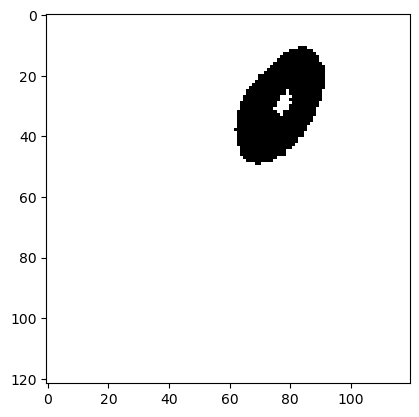

In [14]:
_, threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(threshold, cmap="gray")

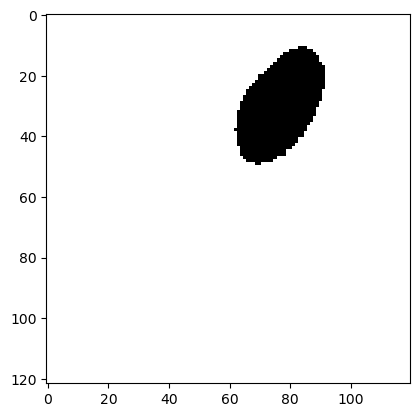

In [15]:
des = cv2.bitwise_not(threshold)
contours, hierarchy = cv2.findContours(des, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

for cnt in contours:
    cv2.drawContours(des, [cnt], 0, 255, -1)

result = cv2.bitwise_not(des)
plt.imshow(result, cmap="gray")

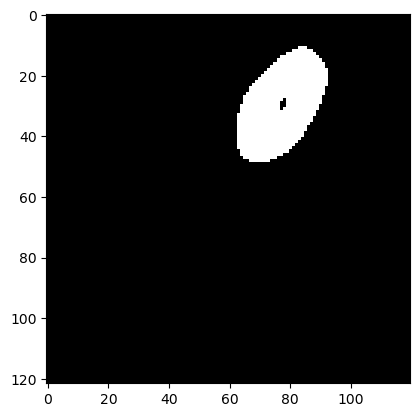

In [16]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
result = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plt.imshow(result, cmap="gray")

In [17]:
# contours, hierarchy = cv2.findContours(result,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

In [18]:
# edges = cv2.Canny(blur, threshold1=150, threshold2=200)
# plt.imshow(edges, cmap="gray")

In [19]:
# contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

valid_contours = []

for i, (contour, h) in enumerate(zip(contours, hierarchy[0])):
    # Check if the contour is not inside another contour (parent index is -1)
    if h[3] == -1:
        area = cv2.contourArea(contour)
        # Check if the area is less than 1200 pixels
        if (area <= 1500) and (area >= 200):
            valid_contours.append(contour)

if valid_contours:
    # Randomly select one of the valid contours
    cnt = random.choice(valid_contours)

else:
    print("No valid contours found.")

In [20]:
# cv2.drawContours(gray, [cnt], 0, (0, 255, 0), 1)
# plt.imshow(gray, cmap="gray")

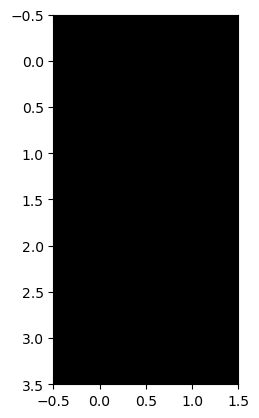

In [21]:
rect = cv2.minAreaRect(cnt)
croped = crop_minAreaRect(gray, rect)
plt.imshow(croped, cmap="gray")

In [26]:
# import hashlib


# def get_hash_with_randomness(file_path):
#     # Generate a random salt
#     salt = os.urandom(16)  # 16 bytes of randomness

#     # Read the file and compute the hash
#     with open(file_path, "rb") as f:
#         file_bytes = f.read()  # read entire file as bytes
#         bytes_with_salt = file_bytes + salt  # append the salt to the file content
#         readable_hash = hashlib.sha256(bytes_with_salt).hexdigest()

#     return readable_hash

In [23]:
# hash_for_filename = get_hash_with_randomness(path)
# print(hash_for_filename)  # This will be your file name

In [24]:
# my_dict = {}
# my_dict.setdefault(readable_hash, [])
# my_dict[readable_hash].append(path)

In [25]:
# my_dict[readable_hash][0]